# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

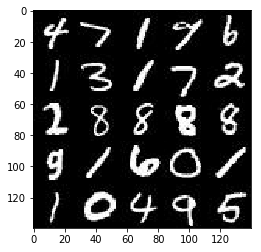

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

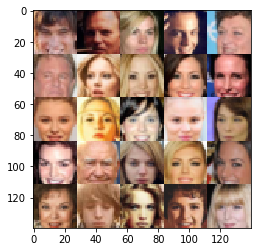

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    fake_inputs = tf.placeholder(tf.float32, shape=[None, z_dim])
    lr = tf.placeholder(tf.float32)
    return real_inputs, fake_inputs, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # 14x14x64 (because of strides / 2)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*256)
        nn = tf.layers.batch_normalization(x, training=is_train)
        
        # Reshape before passing to conv layer
        nn = tf.reshape(nn, (-1, 7, 7, 256))
        # Leaky relu
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 7, 7, 256)
        
        nn = tf.layers.conv2d_transpose(nn, 128, (5, 5), strides=1, padding='same')
        nn = tf.layers.batch_normalization(nn, training=is_train)
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 7, 7, 128) # because of stride 1
        
        nn = tf.layers.conv2d_transpose(nn, 64, (5, 5), strides=2, padding='same')
        nn = tf.layers.batch_normalization(nn, training=is_train)
        nn = tf.maximum(alpha * nn, nn)
        # shape=(?, 14, 14, 64)
    
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(nn, out_channel_dim, (5, 5), strides=2, padding='same')
        out = tf.tanh(logits)
            
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          show_every=100, print_every=15):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create the model inputs
    real_inputs, fake_inputs, lr_tensor = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # Get the loss for the discriminator and generator
    d_loss, g_loss = model_loss(real_inputs, fake_inputs, data_shape[3])
    
    # Get optimization operations
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_tensor, beta1)
    
    losses = []
    n_img_show = 20
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                sess.run(d_train_opt, feed_dict={real_inputs: batch_images, 
                                                 fake_inputs: batch_z, 
                                                 lr_tensor: learning_rate})
                
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, 
                                                 fake_inputs: batch_z, 
                                                 lr_tensor: learning_rate})
                
                if step % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({real_inputs: batch_images, fake_inputs: batch_z})
                    train_loss_g = g_loss.eval({fake_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        show_generator_output(sess, n_img_show, fake_inputs, data_shape[3], data_image_mode)
        print("Last train discriminator Loss: {:.4f}\nLast train generator Loss: {:.4f}".format(losses[-1][0], losses[-1][1]))
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 15.8313... Generator Loss: 0.0000


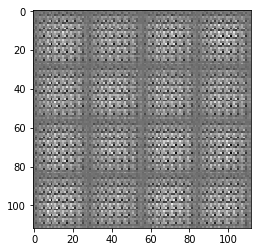

Epoch 1/2... Discriminator Loss: 0.1332... Generator Loss: 2.5368
Epoch 1/2... Discriminator Loss: 0.2020... Generator Loss: 2.8284
Epoch 1/2... Discriminator Loss: 2.6402... Generator Loss: 0.1122
Epoch 1/2... Discriminator Loss: 0.2836... Generator Loss: 2.2457
Epoch 1/2... Discriminator Loss: 0.3661... Generator Loss: 3.0472
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 0.9916


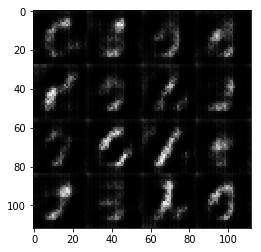

Epoch 1/2... Discriminator Loss: 0.5819... Generator Loss: 3.7237
Epoch 1/2... Discriminator Loss: 0.2384... Generator Loss: 2.4022
Epoch 1/2... Discriminator Loss: 0.1092... Generator Loss: 2.9189
Epoch 1/2... Discriminator Loss: 0.0492... Generator Loss: 3.6968
Epoch 1/2... Discriminator Loss: 0.1018... Generator Loss: 3.0585
Epoch 1/2... Discriminator Loss: 0.6989... Generator Loss: 3.1512
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 1.1367


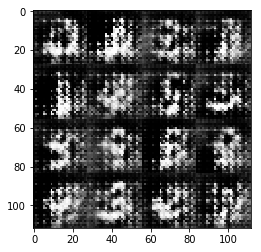

Epoch 1/2... Discriminator Loss: 0.6884... Generator Loss: 2.6252
Epoch 1/2... Discriminator Loss: 0.5969... Generator Loss: 4.4778
Epoch 1/2... Discriminator Loss: 0.9020... Generator Loss: 1.1516
Epoch 1/2... Discriminator Loss: 0.2943... Generator Loss: 2.5471
Epoch 1/2... Discriminator Loss: 0.4773... Generator Loss: 5.2162
Epoch 1/2... Discriminator Loss: 0.2077... Generator Loss: 3.0211
Epoch 1/2... Discriminator Loss: 0.0755... Generator Loss: 4.8480


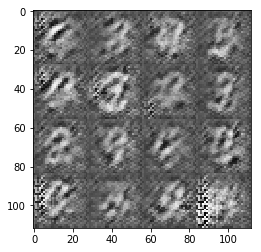

Epoch 1/2... Discriminator Loss: 2.3797... Generator Loss: 0.1241
Epoch 1/2... Discriminator Loss: 0.5022... Generator Loss: 1.6963
Epoch 1/2... Discriminator Loss: 0.7261... Generator Loss: 0.9142
Epoch 1/2... Discriminator Loss: 0.3566... Generator Loss: 1.8378
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.4063
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 1.7866


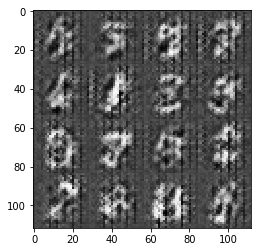

Epoch 1/2... Discriminator Loss: 0.1533... Generator Loss: 2.4793
Epoch 1/2... Discriminator Loss: 0.5210... Generator Loss: 1.3437
Epoch 1/2... Discriminator Loss: 0.3897... Generator Loss: 1.6650
Epoch 1/2... Discriminator Loss: 0.0681... Generator Loss: 3.5619
Epoch 1/2... Discriminator Loss: 0.0635... Generator Loss: 3.8179
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.5556
Epoch 1/2... Discriminator Loss: 0.7868... Generator Loss: 2.1921


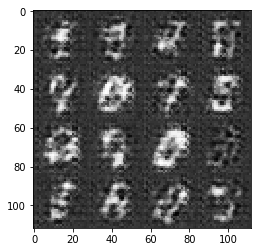

Epoch 1/2... Discriminator Loss: 0.4214... Generator Loss: 1.2830
Epoch 1/2... Discriminator Loss: 0.3269... Generator Loss: 1.5595
Epoch 1/2... Discriminator Loss: 0.2099... Generator Loss: 2.1771
Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 1.3134
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 0.5027... Generator Loss: 1.1800
Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.6042


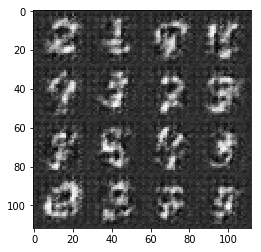

Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.2534
Epoch 1/2... Discriminator Loss: 0.5887... Generator Loss: 1.7764
Epoch 1/2... Discriminator Loss: 0.3707... Generator Loss: 2.3298
Epoch 1/2... Discriminator Loss: 0.7238... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 0.1081... Generator Loss: 2.8741
Epoch 1/2... Discriminator Loss: 0.1934... Generator Loss: 2.1018


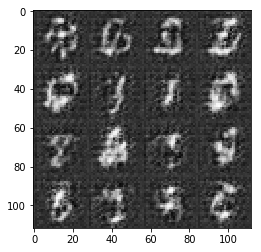

Epoch 1/2... Discriminator Loss: 0.2567... Generator Loss: 1.8980
Epoch 1/2... Discriminator Loss: 0.0466... Generator Loss: 3.9951
Epoch 1/2... Discriminator Loss: 0.0674... Generator Loss: 3.3211
Epoch 1/2... Discriminator Loss: 0.6437... Generator Loss: 1.1928
Epoch 1/2... Discriminator Loss: 0.7754... Generator Loss: 0.8508
Epoch 1/2... Discriminator Loss: 0.9655... Generator Loss: 0.6085
Epoch 1/2... Discriminator Loss: 0.3762... Generator Loss: 1.5162


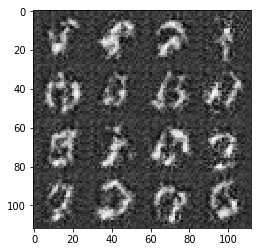

Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 2.9674
Epoch 1/2... Discriminator Loss: 1.1280... Generator Loss: 2.0437
Epoch 1/2... Discriminator Loss: 0.7613... Generator Loss: 2.7057
Epoch 1/2... Discriminator Loss: 0.6578... Generator Loss: 0.9516
Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 1.2644
Epoch 1/2... Discriminator Loss: 0.0916... Generator Loss: 2.8957
Epoch 1/2... Discriminator Loss: 0.3794... Generator Loss: 1.6029


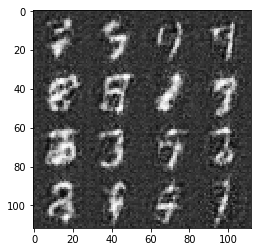

Epoch 1/2... Discriminator Loss: 0.1977... Generator Loss: 2.0174
Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 0.9758
Epoch 1/2... Discriminator Loss: 0.0432... Generator Loss: 4.2058
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 5.0518
Epoch 1/2... Discriminator Loss: 0.0733... Generator Loss: 3.1649
Epoch 1/2... Discriminator Loss: 0.1311... Generator Loss: 2.3963


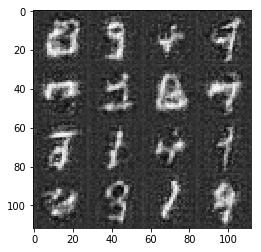

Epoch 1/2... Discriminator Loss: 0.1039... Generator Loss: 2.8066
Epoch 1/2... Discriminator Loss: 0.1155... Generator Loss: 2.8161
Epoch 1/2... Discriminator Loss: 0.0121... Generator Loss: 4.9872
Epoch 1/2... Discriminator Loss: 0.0429... Generator Loss: 3.7274
Epoch 1/2... Discriminator Loss: 0.0151... Generator Loss: 4.7280
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 0.8577
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 1.0871


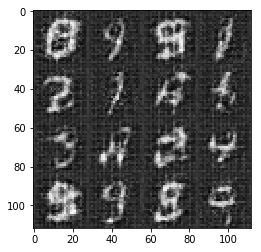

Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 1.5188
Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 0.6761
Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 1.2460
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.7857
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 0.7689... Generator Loss: 1.6493
Epoch 1/2... Discriminator Loss: 0.7002... Generator Loss: 2.0017


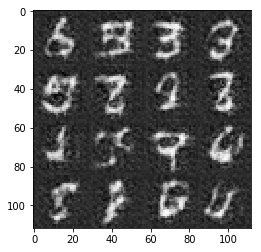

Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 3.6844
Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 2.2768
Epoch 1/2... Discriminator Loss: 0.7331... Generator Loss: 1.0001
Epoch 1/2... Discriminator Loss: 0.5890... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 0.5825


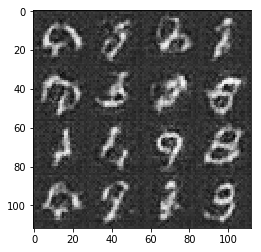

Epoch 1/2... Discriminator Loss: 0.4141... Generator Loss: 1.5642
Epoch 1/2... Discriminator Loss: 1.0484... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 0.3401... Generator Loss: 2.1050
Epoch 1/2... Discriminator Loss: 0.5229... Generator Loss: 1.2040
Epoch 1/2... Discriminator Loss: 0.3060... Generator Loss: 1.8053
Epoch 1/2... Discriminator Loss: 4.8554... Generator Loss: 0.0124
Epoch 1/2... Discriminator Loss: 0.6341... Generator Loss: 0.9988


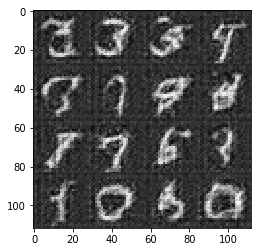

Epoch 1/2... Discriminator Loss: 0.3999... Generator Loss: 1.4079
Epoch 1/2... Discriminator Loss: 0.3479... Generator Loss: 1.5550
Epoch 1/2... Discriminator Loss: 2.8633... Generator Loss: 5.2602
Epoch 1/2... Discriminator Loss: 0.5432... Generator Loss: 1.1904
Epoch 1/2... Discriminator Loss: 0.3595... Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 0.1898... Generator Loss: 2.1825
Epoch 1/2... Discriminator Loss: 0.2235... Generator Loss: 2.0671


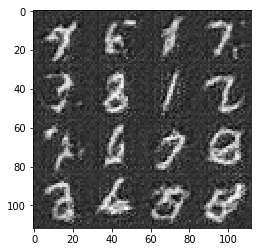

Epoch 1/2... Discriminator Loss: 0.1420... Generator Loss: 2.5818
Epoch 1/2... Discriminator Loss: 0.0710... Generator Loss: 3.2368
Epoch 1/2... Discriminator Loss: 0.0153... Generator Loss: 5.6386
Epoch 1/2... Discriminator Loss: 0.0678... Generator Loss: 3.2165
Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 5.4452
Epoch 1/2... Discriminator Loss: 0.3020... Generator Loss: 1.7637


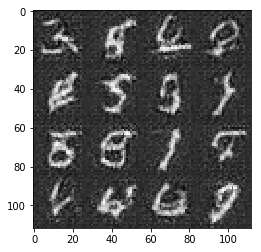

Epoch 1/2... Discriminator Loss: 0.0368... Generator Loss: 4.9747
Epoch 1/2... Discriminator Loss: 0.0579... Generator Loss: 3.5936
Epoch 1/2... Discriminator Loss: 0.0114... Generator Loss: 5.9302
Epoch 1/2... Discriminator Loss: 0.1171... Generator Loss: 2.6635
Epoch 1/2... Discriminator Loss: 0.0834... Generator Loss: 3.0440
Epoch 1/2... Discriminator Loss: 0.0636... Generator Loss: 3.4470
Epoch 1/2... Discriminator Loss: 0.0534... Generator Loss: 3.3993


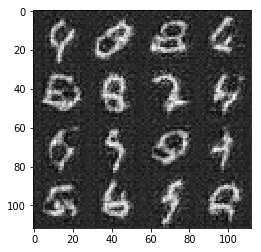

Epoch 1/2... Discriminator Loss: 0.0162... Generator Loss: 4.8970
Epoch 1/2... Discriminator Loss: 0.0232... Generator Loss: 5.1386
Epoch 1/2... Discriminator Loss: 0.0126... Generator Loss: 5.2662
Epoch 1/2... Discriminator Loss: 0.0409... Generator Loss: 3.7115
Epoch 1/2... Discriminator Loss: 1.1010... Generator Loss: 1.3662
Epoch 1/2... Discriminator Loss: 0.7530... Generator Loss: 1.7299
Epoch 1/2... Discriminator Loss: 1.2738... Generator Loss: 0.4778


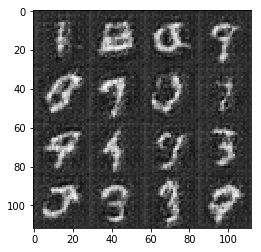

Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 0.7009... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.8015
Epoch 1/2... Discriminator Loss: 0.5009... Generator Loss: 2.0304
Epoch 2/2... Discriminator Loss: 0.3590... Generator Loss: 2.2649


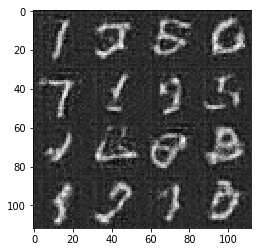

Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 0.5490... Generator Loss: 2.7519
Epoch 2/2... Discriminator Loss: 0.6117... Generator Loss: 1.1284
Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 3.7634
Epoch 2/2... Discriminator Loss: 0.6500... Generator Loss: 1.0389
Epoch 2/2... Discriminator Loss: 0.2912... Generator Loss: 2.8299


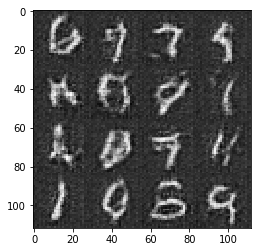

Epoch 2/2... Discriminator Loss: 1.2091... Generator Loss: 0.4259
Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 0.8398
Epoch 2/2... Discriminator Loss: 0.4647... Generator Loss: 1.2985
Epoch 2/2... Discriminator Loss: 0.2086... Generator Loss: 2.0040
Epoch 2/2... Discriminator Loss: 0.1514... Generator Loss: 2.4665
Epoch 2/2... Discriminator Loss: 0.2533... Generator Loss: 1.7922
Epoch 2/2... Discriminator Loss: 0.3167... Generator Loss: 1.7391


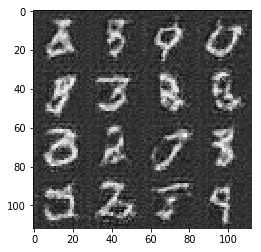

Epoch 2/2... Discriminator Loss: 0.3900... Generator Loss: 1.4702
Epoch 2/2... Discriminator Loss: 0.0164... Generator Loss: 5.5417
Epoch 2/2... Discriminator Loss: 0.0423... Generator Loss: 3.6054
Epoch 2/2... Discriminator Loss: 0.0409... Generator Loss: 3.9848
Epoch 2/2... Discriminator Loss: 0.0109... Generator Loss: 6.3523
Epoch 2/2... Discriminator Loss: 8.2660... Generator Loss: 0.0006
Epoch 2/2... Discriminator Loss: 0.6174... Generator Loss: 1.6078


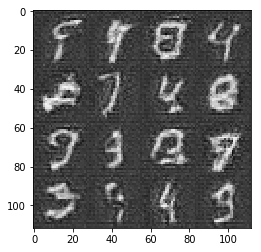

Epoch 2/2... Discriminator Loss: 0.6819... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 0.4133... Generator Loss: 2.3343
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 0.5378... Generator Loss: 3.9837
Epoch 2/2... Discriminator Loss: 2.2631... Generator Loss: 0.1930
Epoch 2/2... Discriminator Loss: 0.3268... Generator Loss: 2.2312


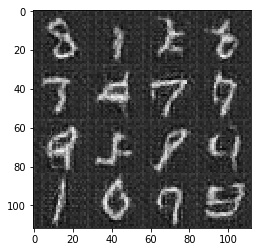

Epoch 2/2... Discriminator Loss: 0.4373... Generator Loss: 1.3672
Epoch 2/2... Discriminator Loss: 0.2505... Generator Loss: 2.1843
Epoch 2/2... Discriminator Loss: 0.5305... Generator Loss: 1.2435
Epoch 2/2... Discriminator Loss: 0.1406... Generator Loss: 2.4628
Epoch 2/2... Discriminator Loss: 0.1816... Generator Loss: 2.1068
Epoch 2/2... Discriminator Loss: 1.7923... Generator Loss: 0.4772
Epoch 2/2... Discriminator Loss: 0.2757... Generator Loss: 2.1845


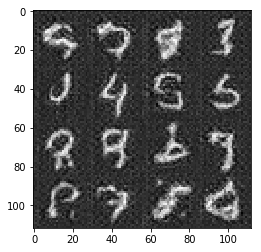

Epoch 2/2... Discriminator Loss: 1.0469... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 0.2912... Generator Loss: 1.8112
Epoch 2/2... Discriminator Loss: 0.0338... Generator Loss: 4.6081
Epoch 2/2... Discriminator Loss: 0.0571... Generator Loss: 4.0324
Epoch 2/2... Discriminator Loss: 0.0523... Generator Loss: 3.6136
Epoch 2/2... Discriminator Loss: 0.1566... Generator Loss: 2.3913
Epoch 2/2... Discriminator Loss: 0.1119... Generator Loss: 2.9431


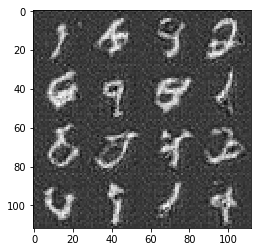

Epoch 2/2... Discriminator Loss: 0.0143... Generator Loss: 5.5101
Epoch 2/2... Discriminator Loss: 0.3803... Generator Loss: 1.5937
Epoch 2/2... Discriminator Loss: 0.0403... Generator Loss: 3.6917
Epoch 2/2... Discriminator Loss: 0.0302... Generator Loss: 4.1426
Epoch 2/2... Discriminator Loss: 0.0120... Generator Loss: 5.8010
Epoch 2/2... Discriminator Loss: 0.0330... Generator Loss: 3.8969


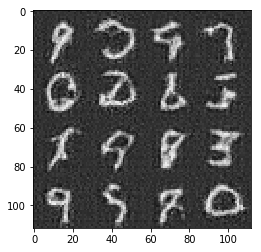

Epoch 2/2... Discriminator Loss: 0.1236... Generator Loss: 2.5646
Epoch 2/2... Discriminator Loss: 0.1272... Generator Loss: 2.6710
Epoch 2/2... Discriminator Loss: 0.0156... Generator Loss: 5.1098
Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 1.1866
Epoch 2/2... Discriminator Loss: 0.6974... Generator Loss: 1.1130
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 0.5400... Generator Loss: 1.1167


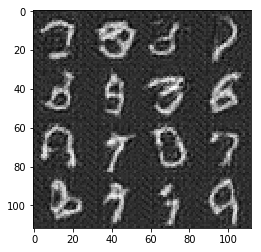

Epoch 2/2... Discriminator Loss: 0.3919... Generator Loss: 2.1670
Epoch 2/2... Discriminator Loss: 0.5224... Generator Loss: 1.2764
Epoch 2/2... Discriminator Loss: 0.8324... Generator Loss: 3.2185
Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 1.6937
Epoch 2/2... Discriminator Loss: 1.4954... Generator Loss: 0.4806
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.5382


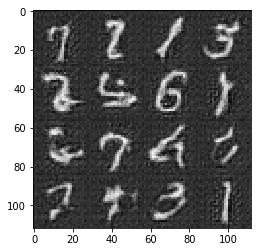

Epoch 2/2... Discriminator Loss: 0.4867... Generator Loss: 1.3011
Epoch 2/2... Discriminator Loss: 0.2673... Generator Loss: 1.7841
Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.1065
Epoch 2/2... Discriminator Loss: 0.0745... Generator Loss: 3.4504
Epoch 2/2... Discriminator Loss: 0.4193... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 0.1479... Generator Loss: 2.5625


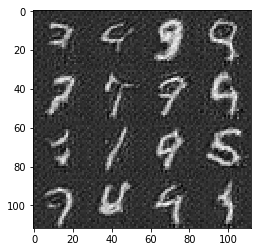

Epoch 2/2... Discriminator Loss: 0.1767... Generator Loss: 2.3467
Epoch 2/2... Discriminator Loss: 0.0784... Generator Loss: 3.1615
Epoch 2/2... Discriminator Loss: 0.0598... Generator Loss: 3.2743
Epoch 2/2... Discriminator Loss: 0.4805... Generator Loss: 1.2602
Epoch 2/2... Discriminator Loss: 0.0225... Generator Loss: 4.3451
Epoch 2/2... Discriminator Loss: 0.1394... Generator Loss: 2.8824
Epoch 2/2... Discriminator Loss: 0.0638... Generator Loss: 3.6259


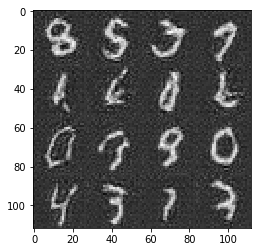

Epoch 2/2... Discriminator Loss: 0.1347... Generator Loss: 2.4035
Epoch 2/2... Discriminator Loss: 0.0025... Generator Loss: 7.0487
Epoch 2/2... Discriminator Loss: 0.0159... Generator Loss: 5.4271
Epoch 2/2... Discriminator Loss: 0.0798... Generator Loss: 3.1662
Epoch 2/2... Discriminator Loss: 0.0066... Generator Loss: 6.2907
Epoch 2/2... Discriminator Loss: 0.0175... Generator Loss: 4.7650
Epoch 2/2... Discriminator Loss: 0.0173... Generator Loss: 4.8225


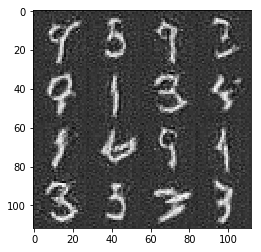

Epoch 2/2... Discriminator Loss: 0.2054... Generator Loss: 2.2152
Epoch 2/2... Discriminator Loss: 0.0755... Generator Loss: 3.4782
Epoch 2/2... Discriminator Loss: 0.0083... Generator Loss: 7.1186
Epoch 2/2... Discriminator Loss: 0.0093... Generator Loss: 5.3877
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 0.9942
Epoch 2/2... Discriminator Loss: 0.1744... Generator Loss: 2.8458


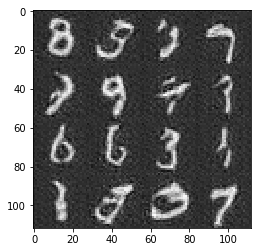

Epoch 2/2... Discriminator Loss: 0.1707... Generator Loss: 2.8050
Epoch 2/2... Discriminator Loss: 0.2405... Generator Loss: 2.1624
Epoch 2/2... Discriminator Loss: 0.6807... Generator Loss: 1.2759
Epoch 2/2... Discriminator Loss: 0.1958... Generator Loss: 2.3957
Epoch 2/2... Discriminator Loss: 0.3783... Generator Loss: 1.8318
Epoch 2/2... Discriminator Loss: 0.7109... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 0.5051... Generator Loss: 1.3914


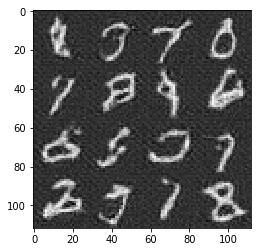

Epoch 2/2... Discriminator Loss: 0.4098... Generator Loss: 1.7734
Epoch 2/2... Discriminator Loss: 0.3010... Generator Loss: 2.0414
Epoch 2/2... Discriminator Loss: 0.1103... Generator Loss: 2.7804
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 1.5798
Epoch 2/2... Discriminator Loss: 0.4362... Generator Loss: 1.4450
Epoch 2/2... Discriminator Loss: 1.3520... Generator Loss: 0.5460
Epoch 2/2... Discriminator Loss: 0.4104... Generator Loss: 2.5019


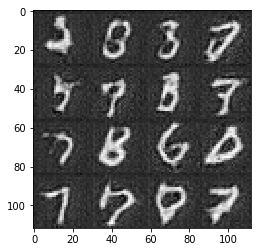

Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 3.1384
Epoch 2/2... Discriminator Loss: 0.3095... Generator Loss: 2.4570
Epoch 2/2... Discriminator Loss: 0.1846... Generator Loss: 2.3602
Epoch 2/2... Discriminator Loss: 0.2652... Generator Loss: 1.9738
Epoch 2/2... Discriminator Loss: 0.2126... Generator Loss: 2.2380
Epoch 2/2... Discriminator Loss: 0.4273... Generator Loss: 1.4091


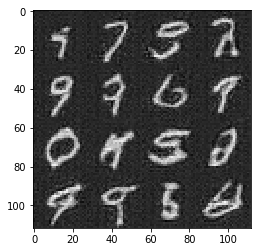

Epoch 2/2... Discriminator Loss: 0.1234... Generator Loss: 2.5828
Epoch 2/2... Discriminator Loss: 0.1533... Generator Loss: 2.5057
Epoch 2/2... Discriminator Loss: 0.0511... Generator Loss: 3.6266
Epoch 2/2... Discriminator Loss: 0.0212... Generator Loss: 4.5338
Epoch 2/2... Discriminator Loss: 0.0957... Generator Loss: 2.9780
Epoch 2/2... Discriminator Loss: 0.0297... Generator Loss: 4.3017
Epoch 2/2... Discriminator Loss: 0.1061... Generator Loss: 2.8705


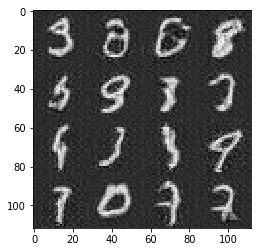

Epoch 2/2... Discriminator Loss: 0.0579... Generator Loss: 3.4258
Epoch 2/2... Discriminator Loss: 0.0469... Generator Loss: 3.9785
Epoch 2/2... Discriminator Loss: 0.0463... Generator Loss: 3.9237
Epoch 2/2... Discriminator Loss: 0.0113... Generator Loss: 5.4055
Epoch 2/2... Discriminator Loss: 0.0119... Generator Loss: 4.9639
Epoch 2/2... Discriminator Loss: 0.0968... Generator Loss: 3.2064
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 7.8610


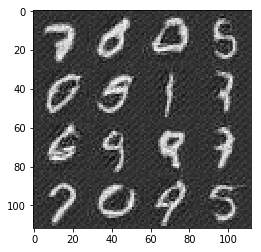

Epoch 2/2... Discriminator Loss: 0.0289... Generator Loss: 4.1599
Epoch 2/2... Discriminator Loss: 0.0439... Generator Loss: 3.8397
Epoch 2/2... Discriminator Loss: 0.0728... Generator Loss: 3.2368
Epoch 2/2... Discriminator Loss: 0.0153... Generator Loss: 4.9733


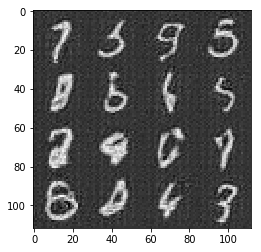

Last train discriminator Loss: 0.0153
Last train generator Loss: 4.9733


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/10... Discriminator Loss: 12.3522... Generator Loss: 0.0000


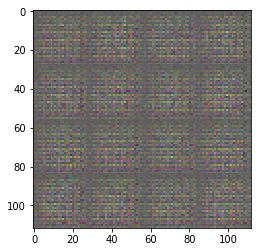

Epoch 1/10... Discriminator Loss: 0.7189... Generator Loss: 0.9814
Epoch 1/10... Discriminator Loss: 0.2266... Generator Loss: 3.3157
Epoch 1/10... Discriminator Loss: 0.1950... Generator Loss: 3.1193
Epoch 1/10... Discriminator Loss: 0.5964... Generator Loss: 2.8069
Epoch 1/10... Discriminator Loss: 0.3915... Generator Loss: 2.0871


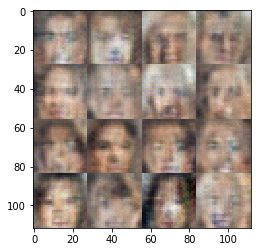

Epoch 1/10... Discriminator Loss: 0.6792... Generator Loss: 0.9612
Epoch 1/10... Discriminator Loss: 0.2725... Generator Loss: 4.1997
Epoch 1/10... Discriminator Loss: 1.2822... Generator Loss: 2.1855
Epoch 1/10... Discriminator Loss: 0.7517... Generator Loss: 0.9341
Epoch 1/10... Discriminator Loss: 1.1676... Generator Loss: 3.1173


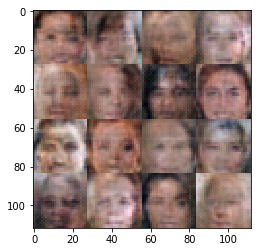

Epoch 1/10... Discriminator Loss: 1.6510... Generator Loss: 0.2810
Epoch 1/10... Discriminator Loss: 0.8033... Generator Loss: 1.0463
Epoch 1/10... Discriminator Loss: 1.3034... Generator Loss: 1.1268
Epoch 1/10... Discriminator Loss: 0.9155... Generator Loss: 1.7306
Epoch 1/10... Discriminator Loss: 1.2707... Generator Loss: 1.5078


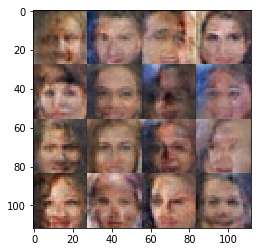

Epoch 1/10... Discriminator Loss: 0.5460... Generator Loss: 1.5436
Epoch 1/10... Discriminator Loss: 1.1955... Generator Loss: 0.5401
Epoch 1/10... Discriminator Loss: 0.7221... Generator Loss: 1.1378
Epoch 1/10... Discriminator Loss: 1.1176... Generator Loss: 0.6207
Epoch 1/10... Discriminator Loss: 0.8121... Generator Loss: 1.0361


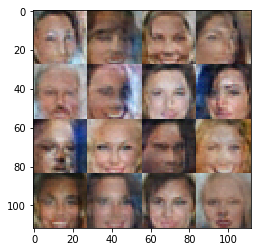

Epoch 1/10... Discriminator Loss: 2.1464... Generator Loss: 2.9428
Epoch 1/10... Discriminator Loss: 0.6841... Generator Loss: 1.1305
Epoch 1/10... Discriminator Loss: 1.0728... Generator Loss: 1.2027
Epoch 1/10... Discriminator Loss: 1.3922... Generator Loss: 0.4222
Epoch 1/10... Discriminator Loss: 1.0277... Generator Loss: 0.6966


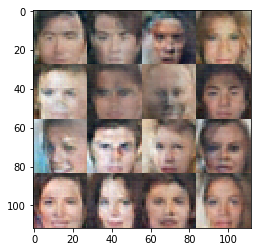

Epoch 1/10... Discriminator Loss: 0.6838... Generator Loss: 1.7471
Epoch 1/10... Discriminator Loss: 1.0390... Generator Loss: 0.8970
Epoch 1/10... Discriminator Loss: 1.2958... Generator Loss: 0.4377
Epoch 1/10... Discriminator Loss: 0.9356... Generator Loss: 0.7387
Epoch 1/10... Discriminator Loss: 0.8471... Generator Loss: 1.2353


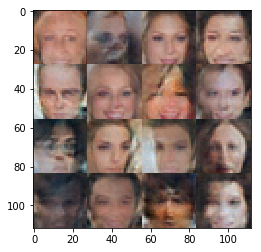

Epoch 1/10... Discriminator Loss: 1.8141... Generator Loss: 0.2830
Epoch 2/10... Discriminator Loss: 1.1069... Generator Loss: 0.5232


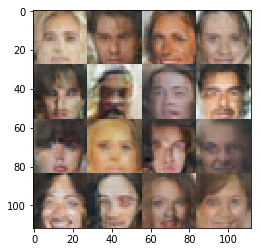

Epoch 2/10... Discriminator Loss: 1.2222... Generator Loss: 0.4758
Epoch 2/10... Discriminator Loss: 0.3481... Generator Loss: 1.9722
Epoch 2/10... Discriminator Loss: 0.6425... Generator Loss: 1.0637
Epoch 2/10... Discriminator Loss: 0.4666... Generator Loss: 2.7518
Epoch 2/10... Discriminator Loss: 0.9199... Generator Loss: 0.7176


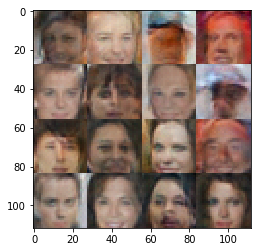

Epoch 2/10... Discriminator Loss: 0.5884... Generator Loss: 1.4787
Epoch 2/10... Discriminator Loss: 0.6883... Generator Loss: 0.9394
Epoch 2/10... Discriminator Loss: 1.2273... Generator Loss: 0.4595
Epoch 2/10... Discriminator Loss: 0.8961... Generator Loss: 0.7475
Epoch 2/10... Discriminator Loss: 0.7376... Generator Loss: 1.0431


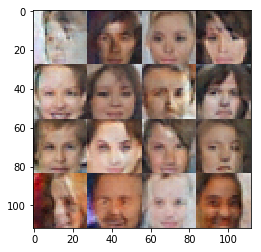

Epoch 2/10... Discriminator Loss: 0.8152... Generator Loss: 0.8589
Epoch 2/10... Discriminator Loss: 0.4169... Generator Loss: 2.2633
Epoch 2/10... Discriminator Loss: 1.6916... Generator Loss: 0.2714
Epoch 2/10... Discriminator Loss: 0.6798... Generator Loss: 0.9117
Epoch 2/10... Discriminator Loss: 1.2249... Generator Loss: 0.4720


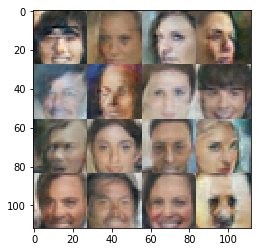

Epoch 2/10... Discriminator Loss: 1.2273... Generator Loss: 0.5805
Epoch 2/10... Discriminator Loss: 0.9010... Generator Loss: 1.1310
Epoch 2/10... Discriminator Loss: 1.0157... Generator Loss: 0.7365
Epoch 2/10... Discriminator Loss: 0.5319... Generator Loss: 1.4419
Epoch 2/10... Discriminator Loss: 0.6590... Generator Loss: 1.1916


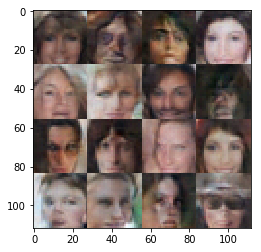

Epoch 2/10... Discriminator Loss: 1.4173... Generator Loss: 0.3955
Epoch 2/10... Discriminator Loss: 0.8455... Generator Loss: 1.1428
Epoch 2/10... Discriminator Loss: 0.4629... Generator Loss: 1.8421
Epoch 2/10... Discriminator Loss: 0.6311... Generator Loss: 1.3581
Epoch 2/10... Discriminator Loss: 0.6599... Generator Loss: 1.1588


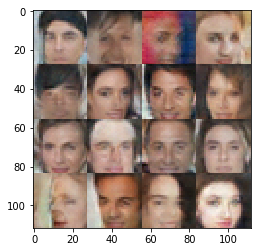

Epoch 2/10... Discriminator Loss: 1.0584... Generator Loss: 2.5864
Epoch 2/10... Discriminator Loss: 1.0269... Generator Loss: 1.3599
Epoch 2/10... Discriminator Loss: 0.9533... Generator Loss: 1.0022
Epoch 2/10... Discriminator Loss: 1.1998... Generator Loss: 0.5585
Epoch 2/10... Discriminator Loss: 1.1183... Generator Loss: 1.1270


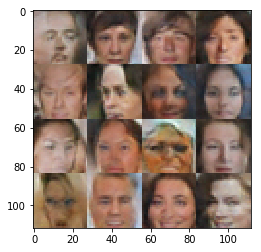

Epoch 2/10... Discriminator Loss: 1.7470... Generator Loss: 3.2014
Epoch 3/10... Discriminator Loss: 1.9447... Generator Loss: 0.2235


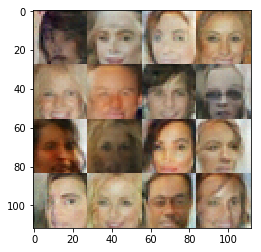

Epoch 3/10... Discriminator Loss: 0.9794... Generator Loss: 0.7335
Epoch 3/10... Discriminator Loss: 1.0773... Generator Loss: 0.6199
Epoch 3/10... Discriminator Loss: 0.9040... Generator Loss: 0.8616
Epoch 3/10... Discriminator Loss: 1.7726... Generator Loss: 0.2447
Epoch 3/10... Discriminator Loss: 0.7686... Generator Loss: 1.0650


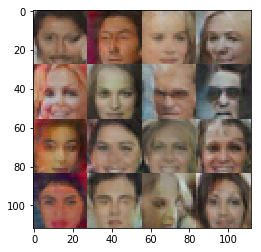

Epoch 3/10... Discriminator Loss: 0.3484... Generator Loss: 1.5846
Epoch 3/10... Discriminator Loss: 0.2713... Generator Loss: 3.1076
Epoch 3/10... Discriminator Loss: 1.5021... Generator Loss: 0.3156
Epoch 3/10... Discriminator Loss: 0.5620... Generator Loss: 1.2832
Epoch 3/10... Discriminator Loss: 1.4615... Generator Loss: 0.3336


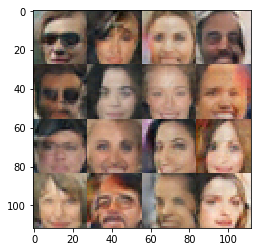

Epoch 3/10... Discriminator Loss: 1.6378... Generator Loss: 0.3946
Epoch 3/10... Discriminator Loss: 0.7687... Generator Loss: 1.0436
Epoch 3/10... Discriminator Loss: 1.5890... Generator Loss: 0.3147
Epoch 3/10... Discriminator Loss: 0.8949... Generator Loss: 1.0457
Epoch 3/10... Discriminator Loss: 0.3439... Generator Loss: 2.2599


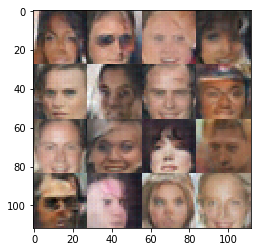

Epoch 3/10... Discriminator Loss: 0.4450... Generator Loss: 1.6783
Epoch 3/10... Discriminator Loss: 0.4964... Generator Loss: 1.1988
Epoch 3/10... Discriminator Loss: 0.6428... Generator Loss: 0.9707
Epoch 3/10... Discriminator Loss: 0.6908... Generator Loss: 1.4240
Epoch 3/10... Discriminator Loss: 0.7674... Generator Loss: 2.3521


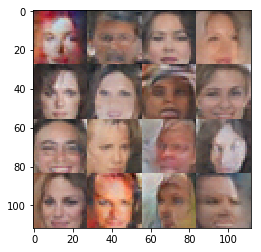

Epoch 3/10... Discriminator Loss: 1.5713... Generator Loss: 0.3413
Epoch 3/10... Discriminator Loss: 0.7973... Generator Loss: 1.3682
Epoch 3/10... Discriminator Loss: 1.3083... Generator Loss: 0.4227
Epoch 3/10... Discriminator Loss: 2.3693... Generator Loss: 0.3653
Epoch 3/10... Discriminator Loss: 0.6280... Generator Loss: 1.2586


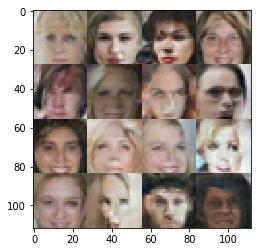

Epoch 3/10... Discriminator Loss: 0.9136... Generator Loss: 0.8082
Epoch 3/10... Discriminator Loss: 0.9741... Generator Loss: 0.6992
Epoch 3/10... Discriminator Loss: 1.4640... Generator Loss: 0.4184
Epoch 3/10... Discriminator Loss: 1.7844... Generator Loss: 0.2784
Epoch 3/10... Discriminator Loss: 1.2843... Generator Loss: 0.4810


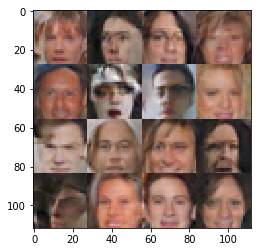

Epoch 3/10... Discriminator Loss: 0.6120... Generator Loss: 1.1658
Epoch 4/10... Discriminator Loss: 2.6638... Generator Loss: 0.1269


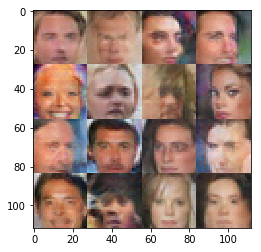

Epoch 4/10... Discriminator Loss: 1.4726... Generator Loss: 0.3335
Epoch 4/10... Discriminator Loss: 0.5878... Generator Loss: 1.5649
Epoch 4/10... Discriminator Loss: 0.8099... Generator Loss: 0.8543
Epoch 4/10... Discriminator Loss: 0.6829... Generator Loss: 1.2675
Epoch 4/10... Discriminator Loss: 0.6545... Generator Loss: 1.4966


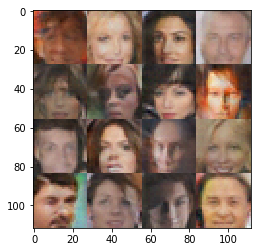

Epoch 4/10... Discriminator Loss: 0.2796... Generator Loss: 2.1134
Epoch 4/10... Discriminator Loss: 0.8535... Generator Loss: 0.7913
Epoch 4/10... Discriminator Loss: 1.7561... Generator Loss: 0.2923
Epoch 4/10... Discriminator Loss: 0.5756... Generator Loss: 1.2155
Epoch 4/10... Discriminator Loss: 0.8982... Generator Loss: 0.7811


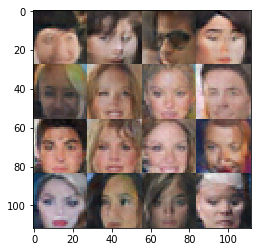

Epoch 4/10... Discriminator Loss: 0.8510... Generator Loss: 0.9737
Epoch 4/10... Discriminator Loss: 0.7026... Generator Loss: 1.5006
Epoch 4/10... Discriminator Loss: 1.1447... Generator Loss: 0.5789
Epoch 4/10... Discriminator Loss: 1.2376... Generator Loss: 0.6098
Epoch 4/10... Discriminator Loss: 0.9851... Generator Loss: 0.9885


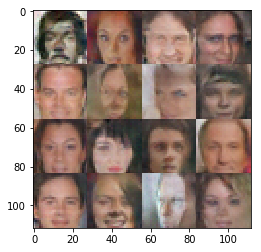

Epoch 4/10... Discriminator Loss: 0.2643... Generator Loss: 2.4249
Epoch 4/10... Discriminator Loss: 0.8809... Generator Loss: 0.8202
Epoch 4/10... Discriminator Loss: 1.3694... Generator Loss: 0.4946
Epoch 4/10... Discriminator Loss: 0.7875... Generator Loss: 0.9952
Epoch 4/10... Discriminator Loss: 0.7875... Generator Loss: 1.7876


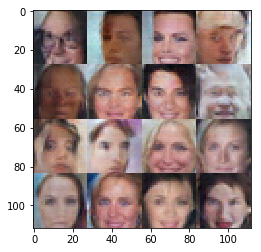

Epoch 4/10... Discriminator Loss: 1.7758... Generator Loss: 0.2330
Epoch 4/10... Discriminator Loss: 0.3342... Generator Loss: 2.3799
Epoch 4/10... Discriminator Loss: 1.5915... Generator Loss: 0.3844
Epoch 4/10... Discriminator Loss: 0.7471... Generator Loss: 1.6641
Epoch 4/10... Discriminator Loss: 1.5001... Generator Loss: 0.4257


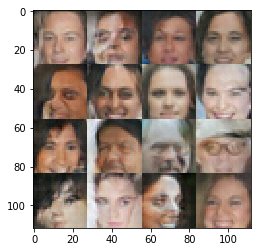

Epoch 4/10... Discriminator Loss: 0.2211... Generator Loss: 2.3739
Epoch 4/10... Discriminator Loss: 0.6776... Generator Loss: 1.2516
Epoch 4/10... Discriminator Loss: 1.5135... Generator Loss: 0.3347
Epoch 4/10... Discriminator Loss: 0.9369... Generator Loss: 0.8002
Epoch 4/10... Discriminator Loss: 3.4422... Generator Loss: 4.2189


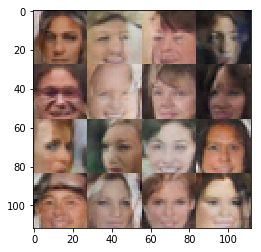

Epoch 4/10... Discriminator Loss: 1.8780... Generator Loss: 0.2480
Epoch 5/10... Discriminator Loss: 1.6674... Generator Loss: 0.2641


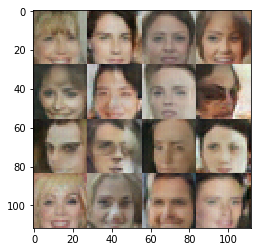

Epoch 5/10... Discriminator Loss: 0.3774... Generator Loss: 1.6595
Epoch 5/10... Discriminator Loss: 0.6376... Generator Loss: 1.3176
Epoch 5/10... Discriminator Loss: 0.6828... Generator Loss: 0.9926
Epoch 5/10... Discriminator Loss: 0.8330... Generator Loss: 0.8789
Epoch 5/10... Discriminator Loss: 0.6935... Generator Loss: 1.0268


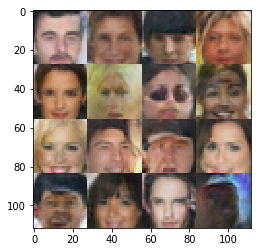

Epoch 5/10... Discriminator Loss: 0.4729... Generator Loss: 1.8884
Epoch 5/10... Discriminator Loss: 0.3619... Generator Loss: 3.9687
Epoch 5/10... Discriminator Loss: 1.4511... Generator Loss: 0.4942
Epoch 5/10... Discriminator Loss: 0.5696... Generator Loss: 1.1228
Epoch 5/10... Discriminator Loss: 0.9565... Generator Loss: 0.6914


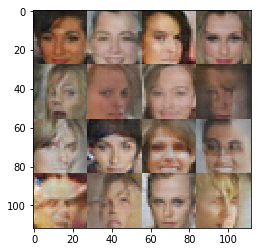

Epoch 5/10... Discriminator Loss: 0.7645... Generator Loss: 1.0624
Epoch 5/10... Discriminator Loss: 1.1114... Generator Loss: 0.5573
Epoch 5/10... Discriminator Loss: 1.3630... Generator Loss: 0.4105
Epoch 5/10... Discriminator Loss: 0.7027... Generator Loss: 1.5755
Epoch 5/10... Discriminator Loss: 0.8283... Generator Loss: 1.0712


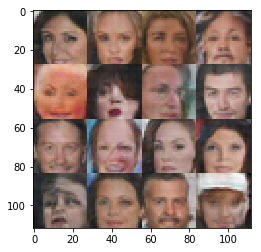

Epoch 5/10... Discriminator Loss: 0.4026... Generator Loss: 1.9026
Epoch 5/10... Discriminator Loss: 0.2970... Generator Loss: 3.9771
Epoch 5/10... Discriminator Loss: 0.7759... Generator Loss: 0.9040
Epoch 5/10... Discriminator Loss: 0.4082... Generator Loss: 1.5202
Epoch 5/10... Discriminator Loss: 0.7481... Generator Loss: 1.1511


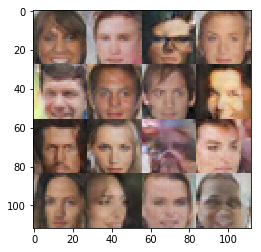

Epoch 5/10... Discriminator Loss: 1.4023... Generator Loss: 0.4642
Epoch 5/10... Discriminator Loss: 0.6117... Generator Loss: 1.1329
Epoch 5/10... Discriminator Loss: 1.0689... Generator Loss: 2.7520
Epoch 5/10... Discriminator Loss: 0.2358... Generator Loss: 2.5287
Epoch 5/10... Discriminator Loss: 2.0718... Generator Loss: 0.1903


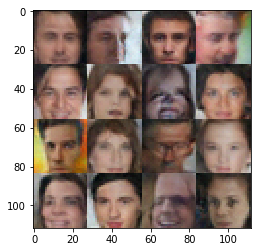

Epoch 5/10... Discriminator Loss: 1.5819... Generator Loss: 4.7470
Epoch 5/10... Discriminator Loss: 0.9541... Generator Loss: 0.8847
Epoch 5/10... Discriminator Loss: 0.9891... Generator Loss: 0.6197
Epoch 5/10... Discriminator Loss: 0.7659... Generator Loss: 0.8781
Epoch 5/10... Discriminator Loss: 1.3485... Generator Loss: 0.5115


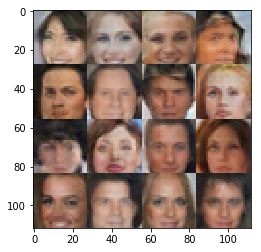

Epoch 5/10... Discriminator Loss: 1.3581... Generator Loss: 0.4852
Epoch 6/10... Discriminator Loss: 1.2757... Generator Loss: 0.4908


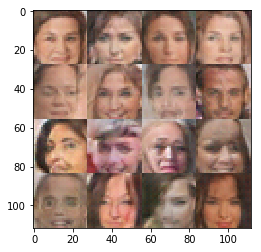

Epoch 6/10... Discriminator Loss: 1.6276... Generator Loss: 0.3142
Epoch 6/10... Discriminator Loss: 1.7222... Generator Loss: 0.3409
Epoch 6/10... Discriminator Loss: 0.7741... Generator Loss: 1.0312
Epoch 6/10... Discriminator Loss: 1.0162... Generator Loss: 0.7342
Epoch 6/10... Discriminator Loss: 0.1888... Generator Loss: 2.7839


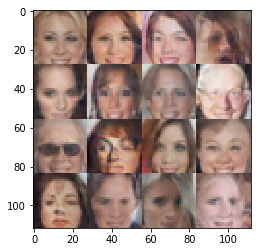

Epoch 6/10... Discriminator Loss: 0.3507... Generator Loss: 1.9136
Epoch 6/10... Discriminator Loss: 1.3970... Generator Loss: 0.4969
Epoch 6/10... Discriminator Loss: 1.2851... Generator Loss: 0.5564
Epoch 6/10... Discriminator Loss: 0.6766... Generator Loss: 0.9832
Epoch 6/10... Discriminator Loss: 0.8495... Generator Loss: 0.8864


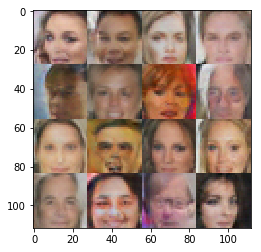

Epoch 6/10... Discriminator Loss: 0.8880... Generator Loss: 0.7354
Epoch 6/10... Discriminator Loss: 0.8160... Generator Loss: 0.8702
Epoch 6/10... Discriminator Loss: 1.6632... Generator Loss: 0.3135
Epoch 6/10... Discriminator Loss: 0.6163... Generator Loss: 2.2918
Epoch 6/10... Discriminator Loss: 1.1322... Generator Loss: 0.6158


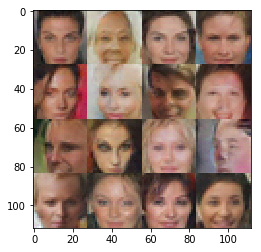

Epoch 6/10... Discriminator Loss: 0.9125... Generator Loss: 0.7189
Epoch 6/10... Discriminator Loss: 0.9258... Generator Loss: 2.1756
Epoch 6/10... Discriminator Loss: 1.1597... Generator Loss: 0.5361
Epoch 6/10... Discriminator Loss: 0.6230... Generator Loss: 1.1404
Epoch 6/10... Discriminator Loss: 0.6767... Generator Loss: 1.0315


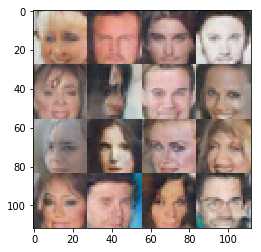

Epoch 6/10... Discriminator Loss: 1.3346... Generator Loss: 0.4877
Epoch 6/10... Discriminator Loss: 0.8309... Generator Loss: 0.7992
Epoch 6/10... Discriminator Loss: 0.5701... Generator Loss: 1.4327
Epoch 6/10... Discriminator Loss: 1.0359... Generator Loss: 0.7144
Epoch 6/10... Discriminator Loss: 0.8026... Generator Loss: 0.8404


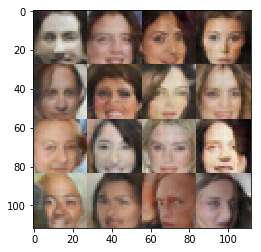

Epoch 6/10... Discriminator Loss: 0.8865... Generator Loss: 0.7707
Epoch 6/10... Discriminator Loss: 1.1048... Generator Loss: 0.4960
Epoch 6/10... Discriminator Loss: 0.9373... Generator Loss: 0.7759
Epoch 6/10... Discriminator Loss: 1.3650... Generator Loss: 0.4654
Epoch 6/10... Discriminator Loss: 0.8577... Generator Loss: 1.0036


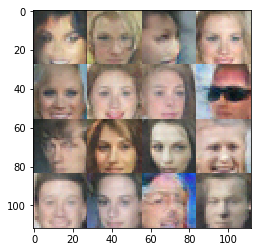

Epoch 6/10... Discriminator Loss: 0.7919... Generator Loss: 0.8918
Epoch 7/10... Discriminator Loss: 0.5678... Generator Loss: 1.2087


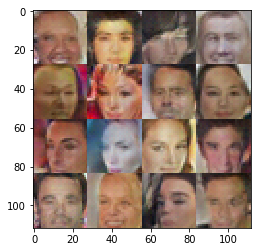

Epoch 7/10... Discriminator Loss: 0.0143... Generator Loss: 5.3739
Epoch 7/10... Discriminator Loss: 0.0207... Generator Loss: 5.3261
Epoch 7/10... Discriminator Loss: 0.0412... Generator Loss: 4.2437
Epoch 7/10... Discriminator Loss: 0.2097... Generator Loss: 2.4034
Epoch 7/10... Discriminator Loss: 0.0960... Generator Loss: 3.1728


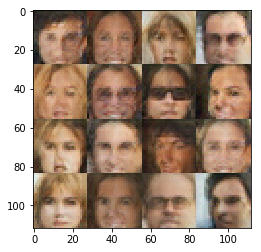

Epoch 7/10... Discriminator Loss: 0.2500... Generator Loss: 2.2379
Epoch 7/10... Discriminator Loss: 0.2121... Generator Loss: 2.7255
Epoch 7/10... Discriminator Loss: 1.7811... Generator Loss: 0.3120
Epoch 7/10... Discriminator Loss: 1.1461... Generator Loss: 3.4117
Epoch 7/10... Discriminator Loss: 0.9606... Generator Loss: 0.8101


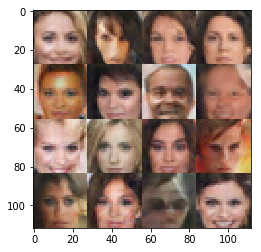

Epoch 7/10... Discriminator Loss: 0.9091... Generator Loss: 0.9138
Epoch 7/10... Discriminator Loss: 1.1680... Generator Loss: 0.6631
Epoch 7/10... Discriminator Loss: 0.3693... Generator Loss: 1.7692
Epoch 7/10... Discriminator Loss: 0.7888... Generator Loss: 1.1643
Epoch 7/10... Discriminator Loss: 0.7650... Generator Loss: 1.1152


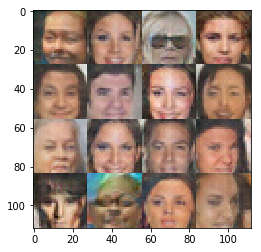

Epoch 7/10... Discriminator Loss: 0.3643... Generator Loss: 1.8560
Epoch 7/10... Discriminator Loss: 1.0618... Generator Loss: 0.5901
Epoch 7/10... Discriminator Loss: 0.9694... Generator Loss: 0.7499
Epoch 7/10... Discriminator Loss: 0.0688... Generator Loss: 4.2093
Epoch 7/10... Discriminator Loss: 0.5946... Generator Loss: 1.1657


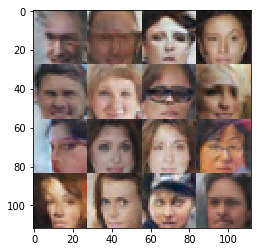

Epoch 7/10... Discriminator Loss: 1.3777... Generator Loss: 0.5335
Epoch 7/10... Discriminator Loss: 0.1115... Generator Loss: 3.1578
Epoch 7/10... Discriminator Loss: 0.2402... Generator Loss: 2.8433
Epoch 7/10... Discriminator Loss: 0.2052... Generator Loss: 2.8938
Epoch 7/10... Discriminator Loss: 0.4618... Generator Loss: 1.6082


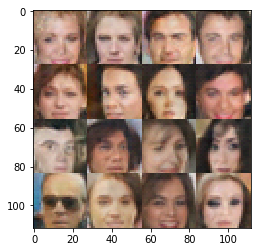

Epoch 7/10... Discriminator Loss: 1.4702... Generator Loss: 0.5420
Epoch 7/10... Discriminator Loss: 0.9275... Generator Loss: 0.6575
Epoch 7/10... Discriminator Loss: 2.1547... Generator Loss: 0.2748
Epoch 7/10... Discriminator Loss: 1.1349... Generator Loss: 0.7998
Epoch 7/10... Discriminator Loss: 1.0675... Generator Loss: 0.6869


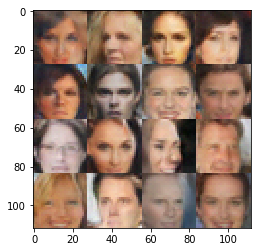

Epoch 7/10... Discriminator Loss: 0.2430... Generator Loss: 2.1895
Epoch 8/10... Discriminator Loss: 1.0558... Generator Loss: 0.8420


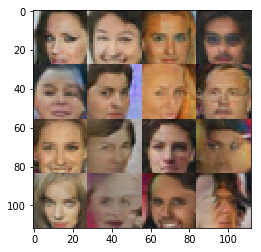

Epoch 8/10... Discriminator Loss: 1.5494... Generator Loss: 0.3763
Epoch 8/10... Discriminator Loss: 3.0381... Generator Loss: 5.9539
Epoch 8/10... Discriminator Loss: 0.5324... Generator Loss: 1.3239
Epoch 8/10... Discriminator Loss: 0.2642... Generator Loss: 2.0227
Epoch 8/10... Discriminator Loss: 0.5560... Generator Loss: 1.2862


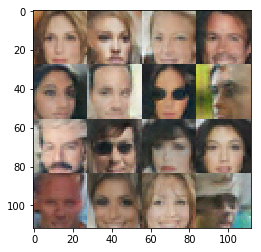

Epoch 8/10... Discriminator Loss: 0.2922... Generator Loss: 2.5177
Epoch 8/10... Discriminator Loss: 0.6925... Generator Loss: 0.9753
Epoch 8/10... Discriminator Loss: 2.1349... Generator Loss: 0.2040
Epoch 8/10... Discriminator Loss: 0.9709... Generator Loss: 0.7465
Epoch 8/10... Discriminator Loss: 0.7405... Generator Loss: 0.9181


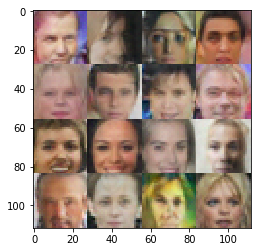

Epoch 8/10... Discriminator Loss: 0.1845... Generator Loss: 3.1098
Epoch 8/10... Discriminator Loss: 0.6061... Generator Loss: 1.0930
Epoch 8/10... Discriminator Loss: 1.3995... Generator Loss: 0.4778
Epoch 8/10... Discriminator Loss: 0.0148... Generator Loss: 5.2893
Epoch 8/10... Discriminator Loss: 0.0003... Generator Loss: 10.6101


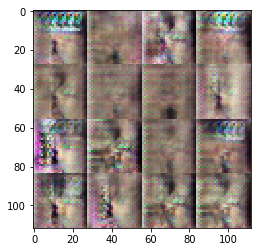

Epoch 8/10... Discriminator Loss: 0.0346... Generator Loss: 4.8078
Epoch 8/10... Discriminator Loss: 0.0744... Generator Loss: 3.6203
Epoch 8/10... Discriminator Loss: 0.0232... Generator Loss: 4.8375
Epoch 8/10... Discriminator Loss: 0.0156... Generator Loss: 5.0666
Epoch 8/10... Discriminator Loss: 0.0320... Generator Loss: 3.9723


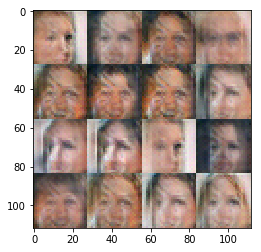

Epoch 8/10... Discriminator Loss: 0.0997... Generator Loss: 3.2599
Epoch 8/10... Discriminator Loss: 0.0177... Generator Loss: 4.8555
Epoch 8/10... Discriminator Loss: 0.0388... Generator Loss: 4.1792
Epoch 8/10... Discriminator Loss: 0.0058... Generator Loss: 6.2387
Epoch 8/10... Discriminator Loss: 0.0044... Generator Loss: 6.7359


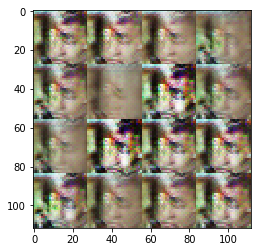

Epoch 8/10... Discriminator Loss: 0.0140... Generator Loss: 5.4040
Epoch 8/10... Discriminator Loss: 0.0796... Generator Loss: 4.4060
Epoch 8/10... Discriminator Loss: 0.0176... Generator Loss: 6.2792
Epoch 8/10... Discriminator Loss: 0.0663... Generator Loss: 4.1666
Epoch 8/10... Discriminator Loss: 0.0500... Generator Loss: 4.4541


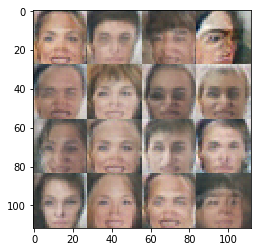

Epoch 8/10... Discriminator Loss: 0.0794... Generator Loss: 3.7296
Epoch 9/10... Discriminator Loss: 0.1015... Generator Loss: 3.2629


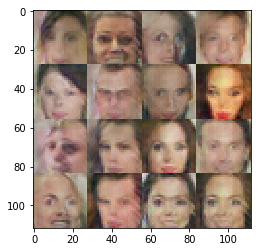

Epoch 9/10... Discriminator Loss: 0.1504... Generator Loss: 3.1534
Epoch 9/10... Discriminator Loss: 0.0635... Generator Loss: 4.6704
Epoch 9/10... Discriminator Loss: 0.0983... Generator Loss: 4.1858
Epoch 9/10... Discriminator Loss: 0.7046... Generator Loss: 1.6095
Epoch 9/10... Discriminator Loss: 0.2827... Generator Loss: 2.4728


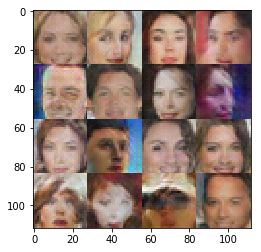

Epoch 9/10... Discriminator Loss: 0.3447... Generator Loss: 1.9015
Epoch 9/10... Discriminator Loss: 0.8378... Generator Loss: 1.1169
Epoch 9/10... Discriminator Loss: 1.0684... Generator Loss: 0.7376
Epoch 9/10... Discriminator Loss: 0.5536... Generator Loss: 1.2572
Epoch 9/10... Discriminator Loss: 0.4891... Generator Loss: 1.4863


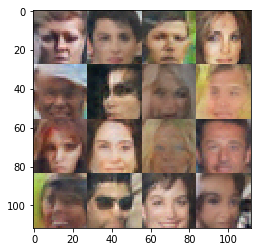

Epoch 9/10... Discriminator Loss: 0.5556... Generator Loss: 1.3412
Epoch 9/10... Discriminator Loss: 0.4927... Generator Loss: 1.3773
Epoch 9/10... Discriminator Loss: 0.6892... Generator Loss: 1.0717
Epoch 9/10... Discriminator Loss: 0.5857... Generator Loss: 1.6230
Epoch 9/10... Discriminator Loss: 0.8941... Generator Loss: 0.8930


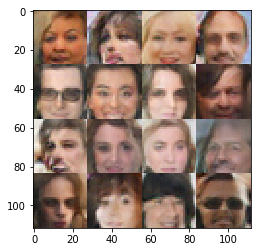

Epoch 9/10... Discriminator Loss: 0.3714... Generator Loss: 1.6625
Epoch 9/10... Discriminator Loss: 0.4163... Generator Loss: 2.0454
Epoch 9/10... Discriminator Loss: 2.6862... Generator Loss: 0.1327
Epoch 9/10... Discriminator Loss: 0.8631... Generator Loss: 0.9039
Epoch 9/10... Discriminator Loss: 0.1074... Generator Loss: 3.0877


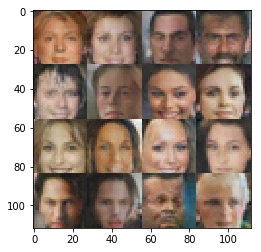

Epoch 9/10... Discriminator Loss: 1.0190... Generator Loss: 0.7002
Epoch 9/10... Discriminator Loss: 0.9152... Generator Loss: 0.7934
Epoch 9/10... Discriminator Loss: 0.9047... Generator Loss: 0.6111
Epoch 9/10... Discriminator Loss: 0.7130... Generator Loss: 0.9932
Epoch 9/10... Discriminator Loss: 0.6562... Generator Loss: 1.2849


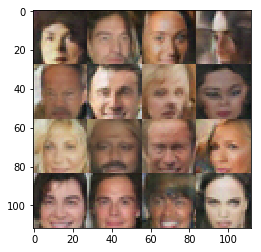

Epoch 9/10... Discriminator Loss: 0.0226... Generator Loss: 5.0837
Epoch 9/10... Discriminator Loss: 0.3544... Generator Loss: 2.3951
Epoch 9/10... Discriminator Loss: 0.8287... Generator Loss: 0.9043
Epoch 9/10... Discriminator Loss: 0.5355... Generator Loss: 1.8837
Epoch 9/10... Discriminator Loss: 1.3162... Generator Loss: 0.4517


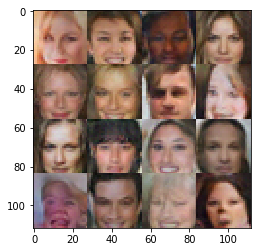

Epoch 9/10... Discriminator Loss: 1.1757... Generator Loss: 0.6138
Epoch 10/10... Discriminator Loss: 1.3402... Generator Loss: 0.7465


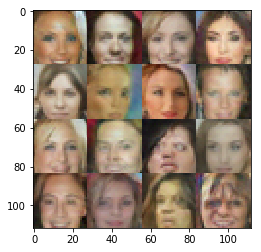

Epoch 10/10... Discriminator Loss: 1.5572... Generator Loss: 0.4109
Epoch 10/10... Discriminator Loss: 1.4083... Generator Loss: 0.8413
Epoch 10/10... Discriminator Loss: 0.2949... Generator Loss: 2.4609
Epoch 10/10... Discriminator Loss: 0.7452... Generator Loss: 1.4363
Epoch 10/10... Discriminator Loss: 0.3951... Generator Loss: 1.5012


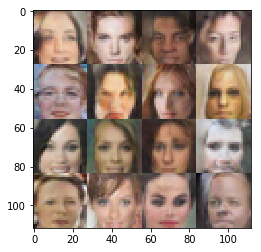

Epoch 10/10... Discriminator Loss: 0.6003... Generator Loss: 0.9636
Epoch 10/10... Discriminator Loss: 0.3416... Generator Loss: 1.8638
Epoch 10/10... Discriminator Loss: 1.1714... Generator Loss: 0.7217
Epoch 10/10... Discriminator Loss: 0.6671... Generator Loss: 1.2111
Epoch 10/10... Discriminator Loss: 0.6703... Generator Loss: 1.3923


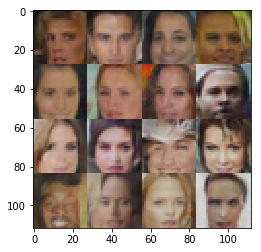

Epoch 10/10... Discriminator Loss: 0.6612... Generator Loss: 1.1011
Epoch 10/10... Discriminator Loss: 0.7847... Generator Loss: 0.9835
Epoch 10/10... Discriminator Loss: 0.4638... Generator Loss: 1.4083
Epoch 10/10... Discriminator Loss: 0.3102... Generator Loss: 2.6033
Epoch 10/10... Discriminator Loss: 0.3287... Generator Loss: 2.2341


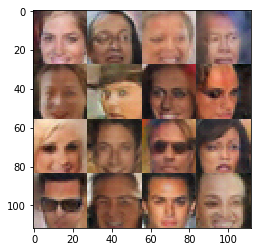

Epoch 10/10... Discriminator Loss: 1.1504... Generator Loss: 0.5692
Epoch 10/10... Discriminator Loss: 0.9050... Generator Loss: 1.3510
Epoch 10/10... Discriminator Loss: 2.0499... Generator Loss: 0.2596
Epoch 10/10... Discriminator Loss: 1.2343... Generator Loss: 0.6893
Epoch 10/10... Discriminator Loss: 0.2561... Generator Loss: 2.4127


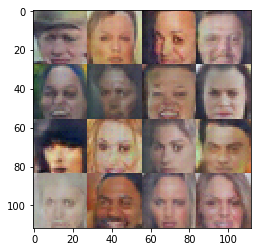

Epoch 10/10... Discriminator Loss: 0.0070... Generator Loss: 6.5324
Epoch 10/10... Discriminator Loss: 0.0622... Generator Loss: 7.4857
Epoch 10/10... Discriminator Loss: 0.0568... Generator Loss: 3.7505
Epoch 10/10... Discriminator Loss: 0.1786... Generator Loss: 2.6901
Epoch 10/10... Discriminator Loss: 0.3039... Generator Loss: 2.0108


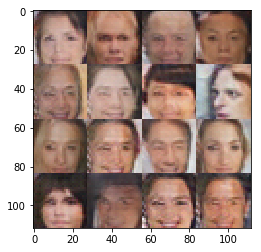

Epoch 10/10... Discriminator Loss: 0.3814... Generator Loss: 1.5648
Epoch 10/10... Discriminator Loss: 1.4751... Generator Loss: 0.7299
Epoch 10/10... Discriminator Loss: 0.5813... Generator Loss: 1.6375
Epoch 10/10... Discriminator Loss: 0.0328... Generator Loss: 6.6144
Epoch 10/10... Discriminator Loss: 0.5624... Generator Loss: 1.8244


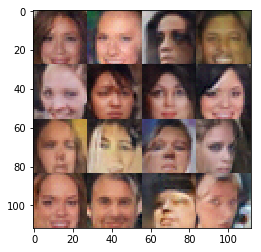

Epoch 10/10... Discriminator Loss: 0.9073... Generator Loss: 0.8364


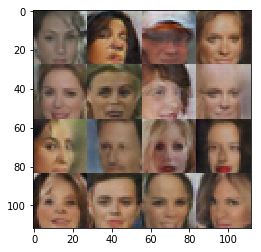

Last train discriminator Loss: 0.9073
Last train generator Loss: 0.8364


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 10

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, show_every=1000, print_every=200)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.